99% 1-Day VaR: $16,746.61
99% 1-Day CVaR (Expected Shortfall): $19,156.78


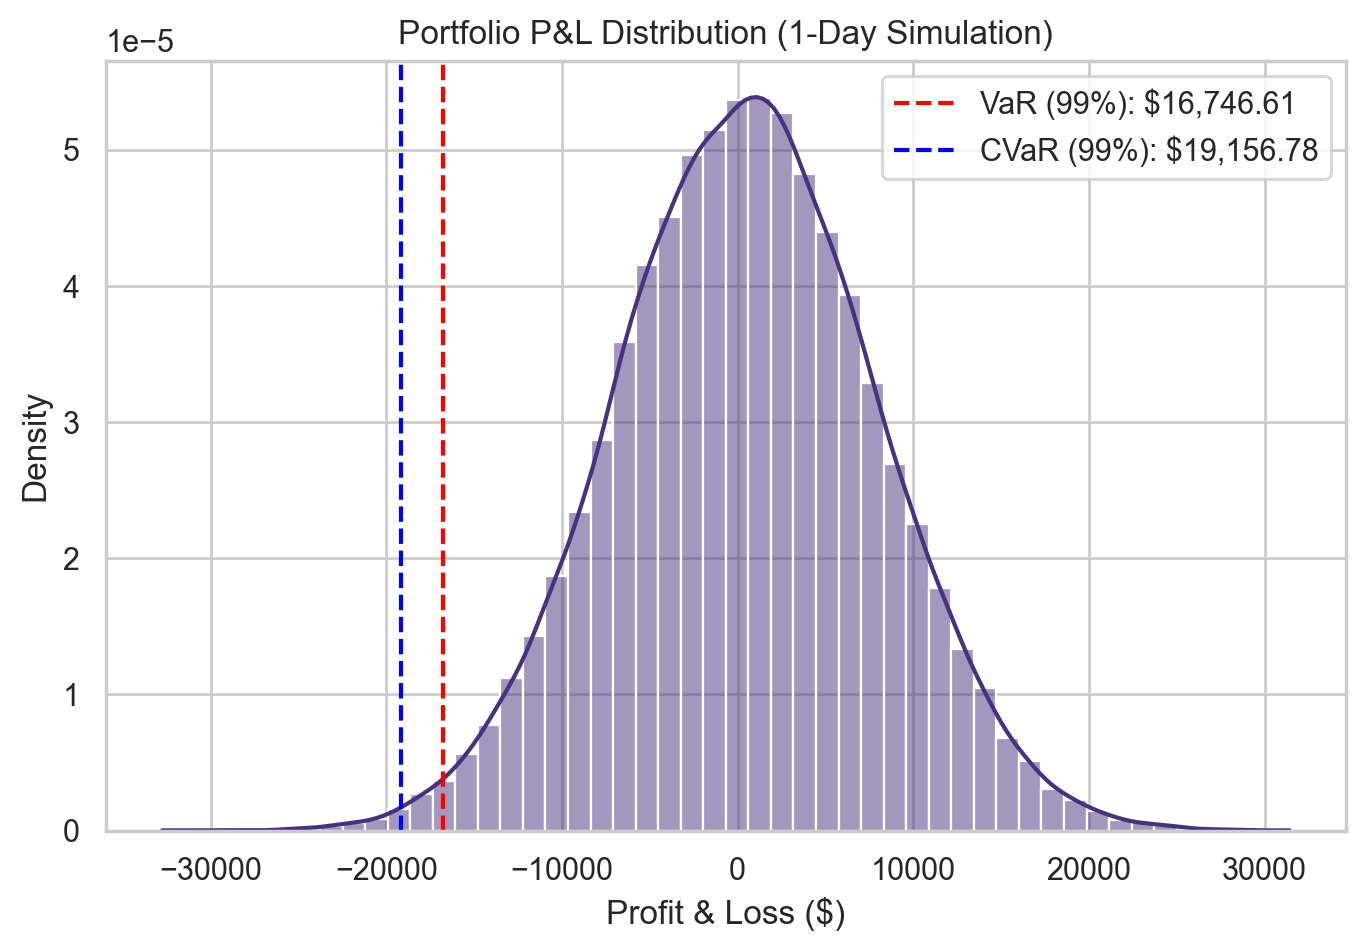

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set_theme(style="whitegrid", palette="viridis")

import sys
sys.path.insert(0, '..')
from modules.mc_portfolio_var import PortfolioVaR

df_full = pd.read_csv('../data/all_stocks_5yr.csv')
df_full['date'] = pd.to_datetime(df_full['date'])
df_full = df_full.set_index('date').sort_index()

df_simple = df_full[['close', 'Name']].copy()
df_wide = df_simple.pivot(columns='Name', values='close')

# Fill missing data
df_wide.ffill(inplace=True)
df_wide.bfill(inplace=True)

portfolio_tickers = ['AAPL', 'JPM', 'JNJ', 'XOM', 'PG', 'DIS', 'CAT', 'NEE']
num_assets = len(portfolio_tickers)
weights = np.array([1 / num_assets] * num_assets)
initial_value = 1_000_000

# Initialize the model with the clean data
var_model = PortfolioVaR(
    price_data=df_wide,
    tickers=portfolio_tickers,
    weights=weights,
    initial_portfolio_value=initial_value
)

pnl_distribution = var_model.run_simulation(T_days=1, n_sims=50000)

VaR_99 = var_model.calculate_var(pnl_distribution, 0.99)
CVaR_99 = var_model.calculate_cvar(pnl_distribution, 0.99)

print(f"99% 1-Day VaR: ${abs(VaR_99):,.2f}")
print(f"99% 1-Day CVaR (Expected Shortfall): ${abs(CVaR_99):,.2f}")

# Visualize the P&L distribution
plt.figure(figsize=(8, 5))
sns.histplot(pnl_distribution, bins=50, kde=True, stat="density")
plt.axvline(VaR_99, color='r', linestyle='--', label=f'VaR (99%): ${abs(VaR_99):,.2f}')
plt.axvline(CVaR_99, color='b', linestyle='--', label=f'CVaR (99%): ${abs(CVaR_99):,.2f}')
plt.title('Portfolio P&L Distribution (1-Day Simulation)')
plt.xlabel('Profit & Loss ($)')
plt.ylabel('Density')
plt.legend()
plt.show()
